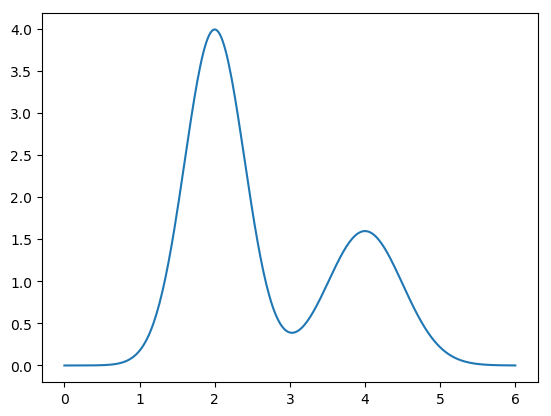

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13652bf60>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("heaviside")(x, y)
end

kernel (generic function with 1 method)

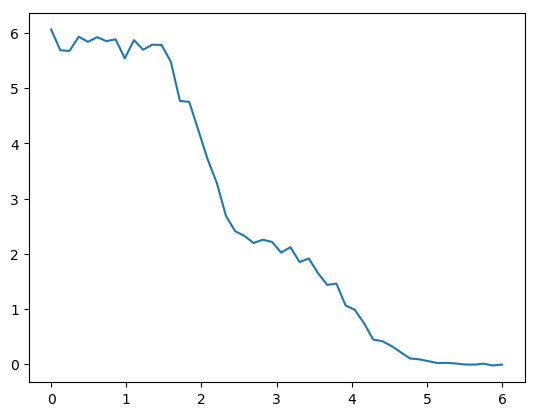

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13673a3c8>

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]
y = collect(range(a, stop=b, length=50))
ftrue = convolution.(y)
sig = 0.05*ftrue + [0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

In [4]:
basis = FourierBasis(a, b, 25)
model = GaussErrorUnfolder(basis, omega(basis, 2))
phi_reconstruct = solve(model, kernel, f, sig, y)
phivec = PhiVec(phi_reconstruct["coeff"], basis, phi_reconstruct["sig"])

starting solve
ending solve
starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -1.223748e+03     1.668966e+00
     1    -1.225606e+03     3.965193e-02
     2    -1.225607e+03     1.544223e-04
     3    -1.225607e+03     1.153344e-07
     4    -1.225607e+03     5.766720e-08
     5    -1.225607e+03     1.922240e-08
     6    -1.225607e+03     0.000000e+00
ending solve_correct


PhiVec([1.95574, 0.871983, -0.477895, -0.5701, -0.29225, -0.423059, 0.0622983, -0.0413335, 0.00449221, 0.00249882  …  7.48759e-6, -1.68575e-6, -1.41411e-7, 4.41461e-6, 2.1094e-6, -1.92592e-6, 2.51104e-8, -3.58581e-7, -9.27655e-9, 2.683e-7], FourierBasis(0.0, 6.0, 25, BaseFunction[BaseFunction(##19#23(), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##21#25{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##20#24{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0))  …  BaseFunction(##20#24{Float64,Float64,Int

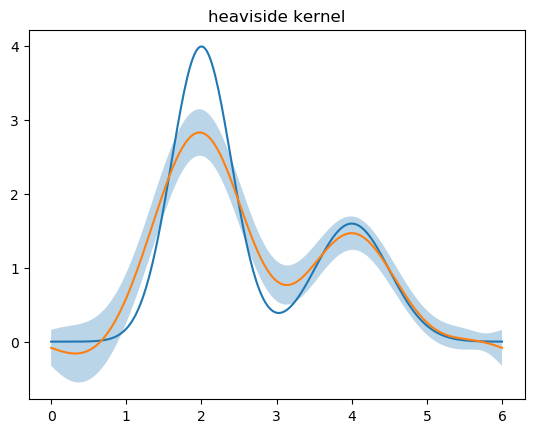

In [5]:
plot(x, phi.(x))
title("heaviside kernel")
phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)
savefig("heaviside_kernel.png")